In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.19 GB, difference +0.19 GB
scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.1 pandas==2.0.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [4]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [5]:
home_dir = os.path.expanduser("~")

In [6]:
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [7]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [8]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [11]:
aml_cells = [
"AML Monocytes 1",
"AML Monocytes 2",
"AML cells 1",
"AML cells 2",
"AML cells 3",
"AML cells 4",
"AML cells 5",
"AML cells 6",
"AML cells 7",
"AML cells 8",
"AML cells 9",
"AML cells 10",
"Cycling AML cells 1",
"Cycling AML cells 2",
"Cycling AML Monocytes",
]

In [12]:
#selecting only AML blasts
print(len(adata))
adata = adata[(adata.obs["cell_type_sub_prolif_anno"].isin(aml_cells)) & (adata.obs["sample"] == "UL")].copy()
print(len(adata))



86447
14011


/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
# Filtering out lower quality cells before reclustering
print(len(adata))
adata = adata[(adata.obs["n_counts"] >= 2000)].copy()
print(len(adata))



14011
9352


In [14]:
cell_type_color_palette = {

"AML cells 1": "#73472a",
"AML cells 2": "#9e5423",
"AML cells 3": "#ab3803",
"AML cells 4": "#eb8f1e",
"AML cells 5": "#f2621f",
"AML cells 6": "#ad0e0e",
"AML cells 7": "#cc1c00",
"AML cells 8": "#db5a46",
"AML cells 9": "#b85c38",
"AML cells 10": "#e07c57",

"Cycling AML cells 1": "#bf4a2e",
"Cycling AML cells 2": "#d96e3a",
  
"AML Monocytes 1": "#8a0303",
"AML Monocytes 2": "#ff7043",

"Cycling AML Monocytes": "#c4371d",

}


/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/anndata/_core/anndata.py:1

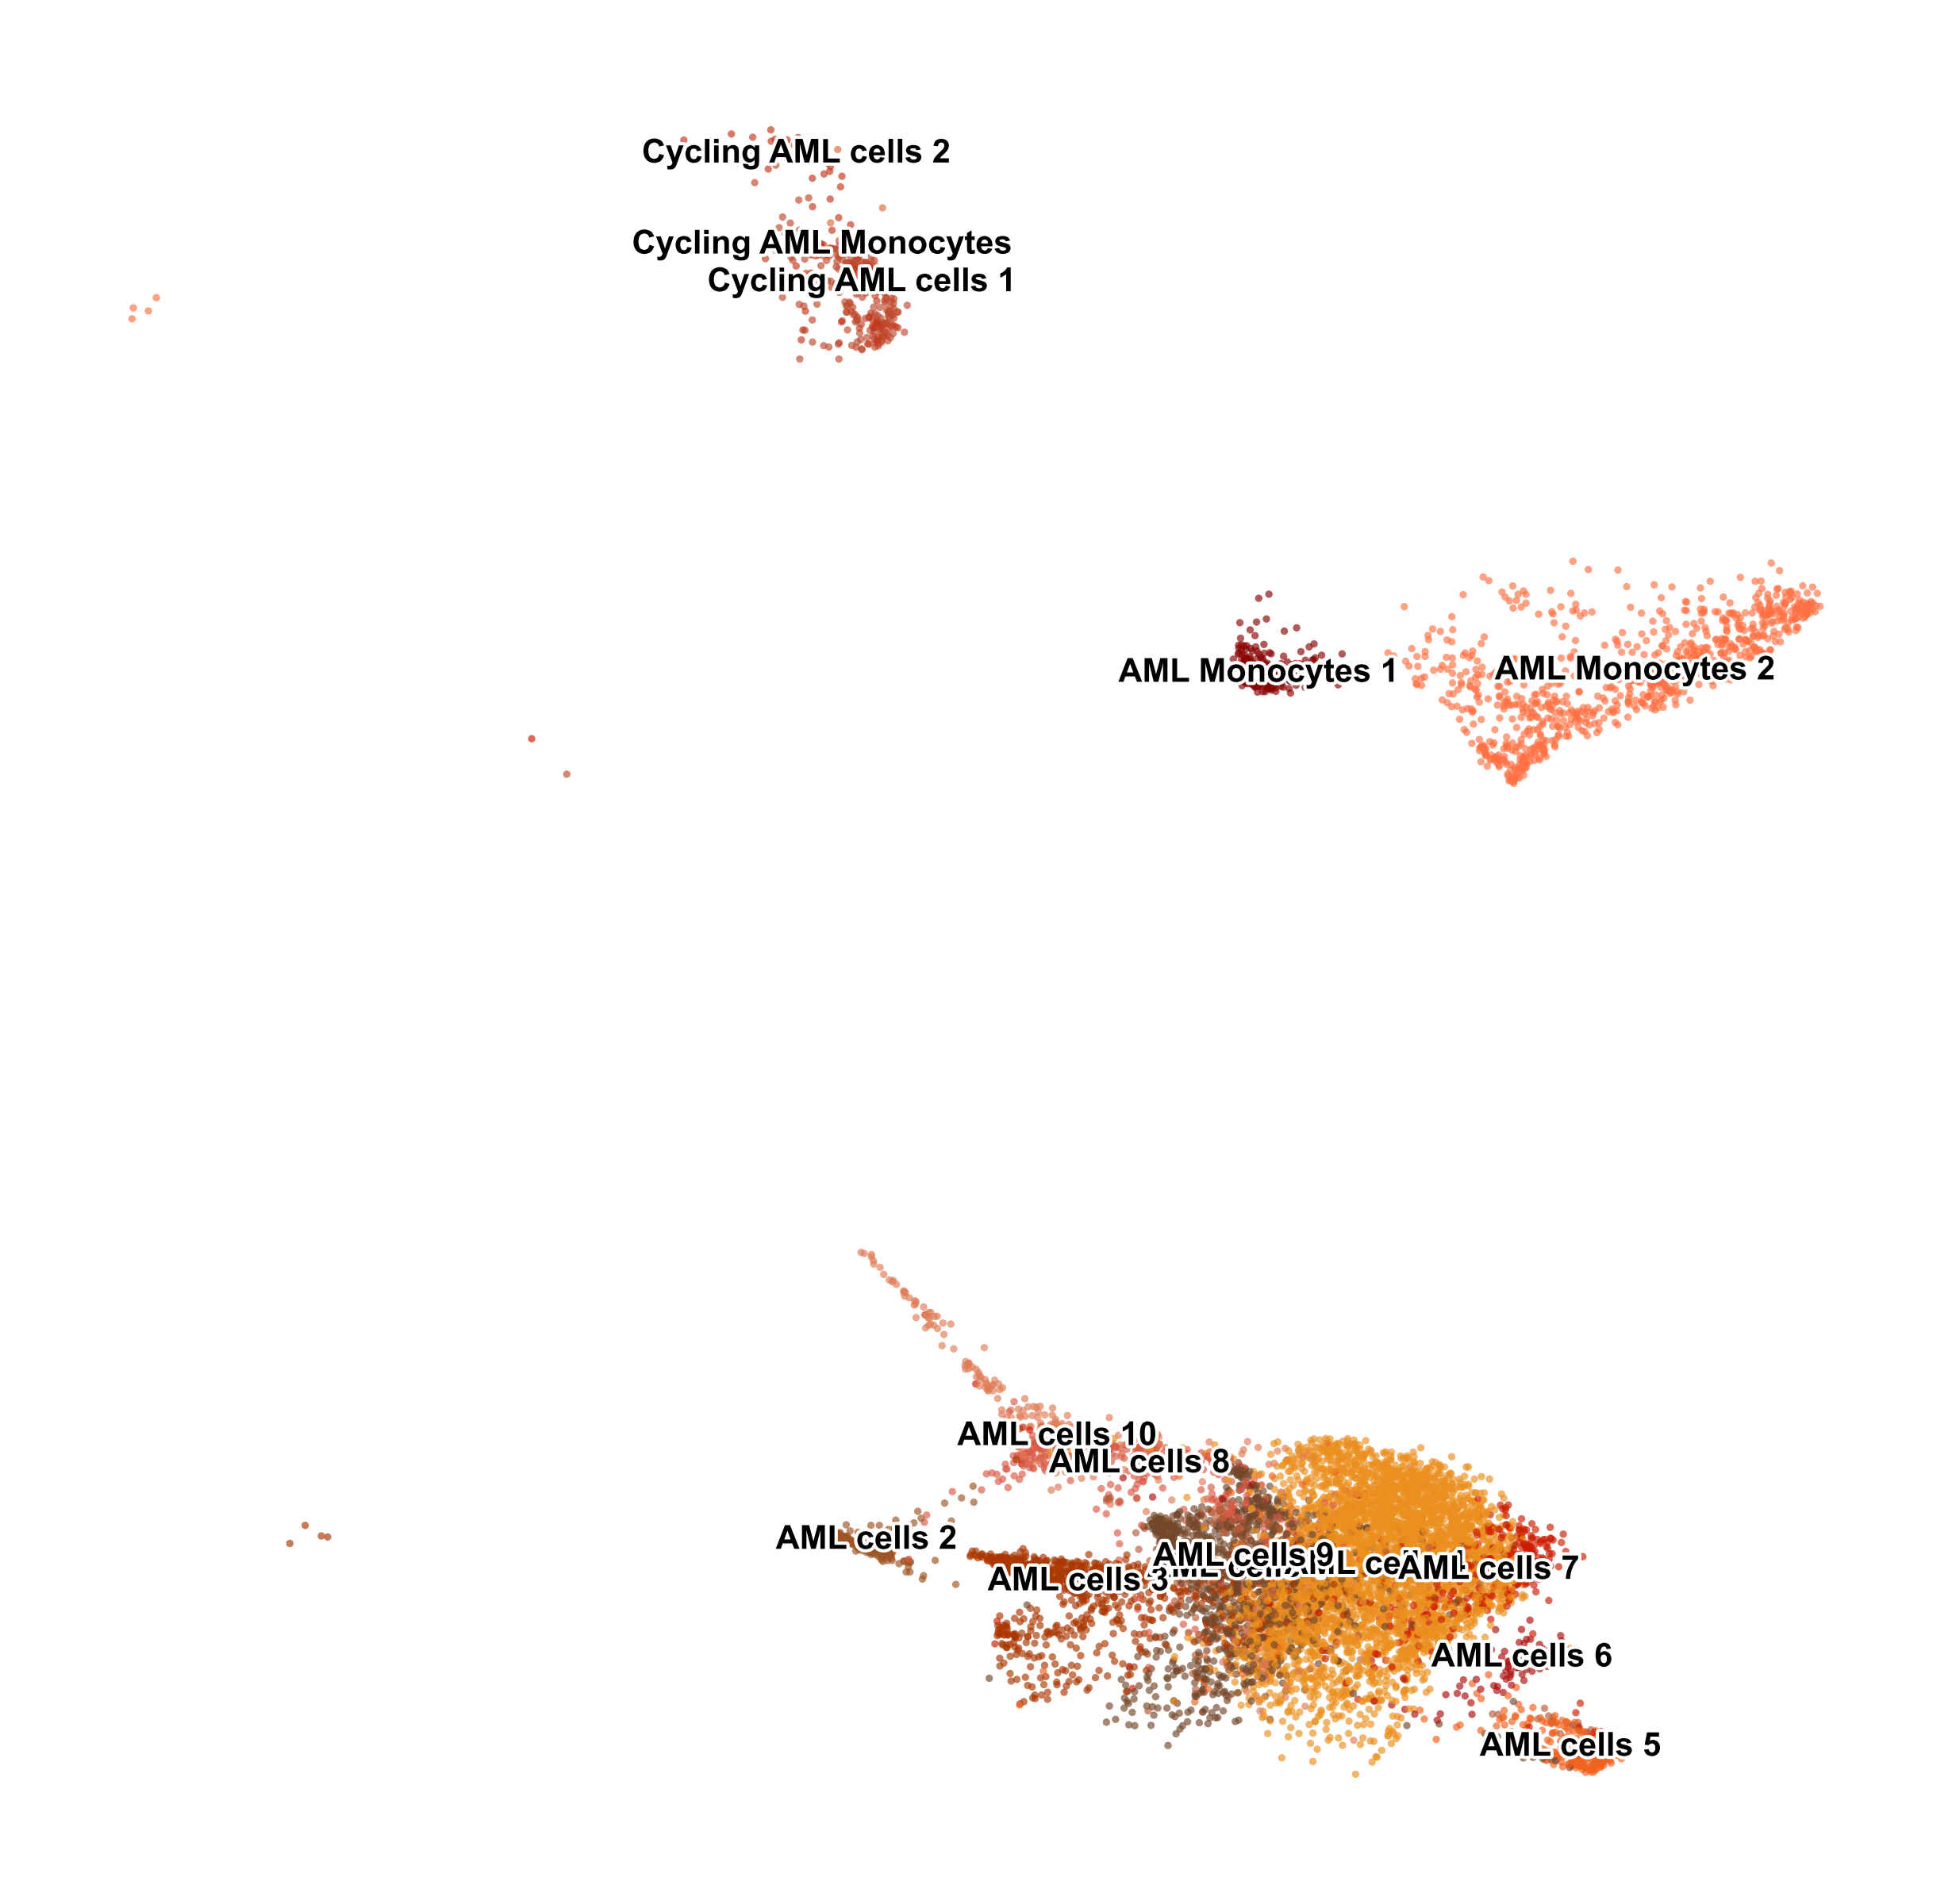

In [15]:
sc.settings.set_figure_params(dpi = 300, 
                              dpi_save = 300, 
                              transparent = True, 
                              figsize = (5, 5), 
                              vector_friendly = False)


# To randomize cells
np.random.seed(69)
random_indices = np.random.permutation(list(range(adata.shape[0])))


sc.pl.umap(adata[random_indices, :], color = "cell_type_sub_prolif_anno", 
           alpha = 0.66, 
           wspace = 0.5,
           ncols = 3,
           s = 5, 
           frameon = False, title = "",
           legend_loc = "on data", legend_fontsize = 5, legend_fontoutline = True, 
           palette = cell_type_color_palette)

In [16]:
# Revert X
adata.X = adata.layers["counts"].copy()
adata.raw = adata

#normalize data
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4) # n_counts is created


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)


In [17]:
adata.layers["counts"].sum(axis = 1)

matrix([[11500.],
        [ 7844.],
        [ 7647.],
        ...,
        [ 2453.],
        [10507.],
        [ 8289.]], dtype=float32)

In [18]:
adata.raw.X.sum(axis = 1)

matrix([[11500.],
        [ 7844.],
        [ 7647.],
        ...,
        [ 2453.],
        [10507.],
        [ 8289.]], dtype=float32)

In [19]:
adata.X.sum(axis = 1)

matrix([[10000.001],
        [10000.001],
        [10000.001],
        ...,
        [10000.   ],
        [10000.001],
        [10000.001]], dtype=float32)

In [20]:
cdata = adata.copy()

In [21]:
# avoid genes starting with
toavoid = ["MT-", "RPS","RPL","MRPL", "MRPS"]
for i in toavoid:
    print(i)
    print([g for g in cdata.var_names if g.startswith(i)])
    print("\n")

MT-
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


RPS
['RPS6KA1', 'RPS8', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPSA', 'RPS3A', 'RPS23', 'RPS14', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPS12', 'RPS6KA2', 'RPS6KA2-IT1', 'RPS6KA2-AS1', 'RPS20', 'RPS6', 'RPS24', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPS29', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPS17', 'RPS2', 'RPS15A', 'RPS6KB1', 'RPS15', 'RPS28', 'RPSAP58', 'RPS16', 'RPS19', 'RPS11', 'RPS9', 'RPS5', 'RPS21', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPS4Y1', 'RPS4Y2']


RPL
['RPL22', 'RPL11', 'RPL5', 'RPL31', 'RPL37A-DT', 'RPL37A', 'RPL32', 'RPL15', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-DT', 'RPL34', 'RPL37', 'RPL26L1-AS1', 'RPL26L1', 'RPL10A', 'RPL7L1', 'RPL7', 'RPL30', 'RPL30-AS1', 'RPL8', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPL3

In [22]:
filter_genes = ["MT-", "RPS","RPL","MRPL", "MRPS"]

print("before mt and ribo removal: ", cdata.n_obs, cdata.n_vars)

mask_gene_list = []
for gene in filter_genes:
    mask_gene = cdata.var_names.str.startswith(gene)
    mask_gene_list.append(mask_gene)
    #remove = np.add(mask_gene)
    
remove = np.sum(mask_gene_list, axis = 0, dtype = bool) 
keep = np.invert(remove)
keep
cdata = cdata[:,keep]

print("after mt and ribo removal: ", cdata.n_obs, cdata.n_vars)

before mt and ribo removal:  9352 37733
after mt and ribo removal:  9352 37528


In [24]:
# Filtering "noisy" genes
gmask = filter_abund_genes(E = cdata.X, min_cells = 5, min_counts = 10)

5969 genes passing abundance filter


In [25]:
cdata = cdata[:,gmask]

In [26]:
#logaritmize data
sc.pp.log1p(cdata)

/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:404: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes


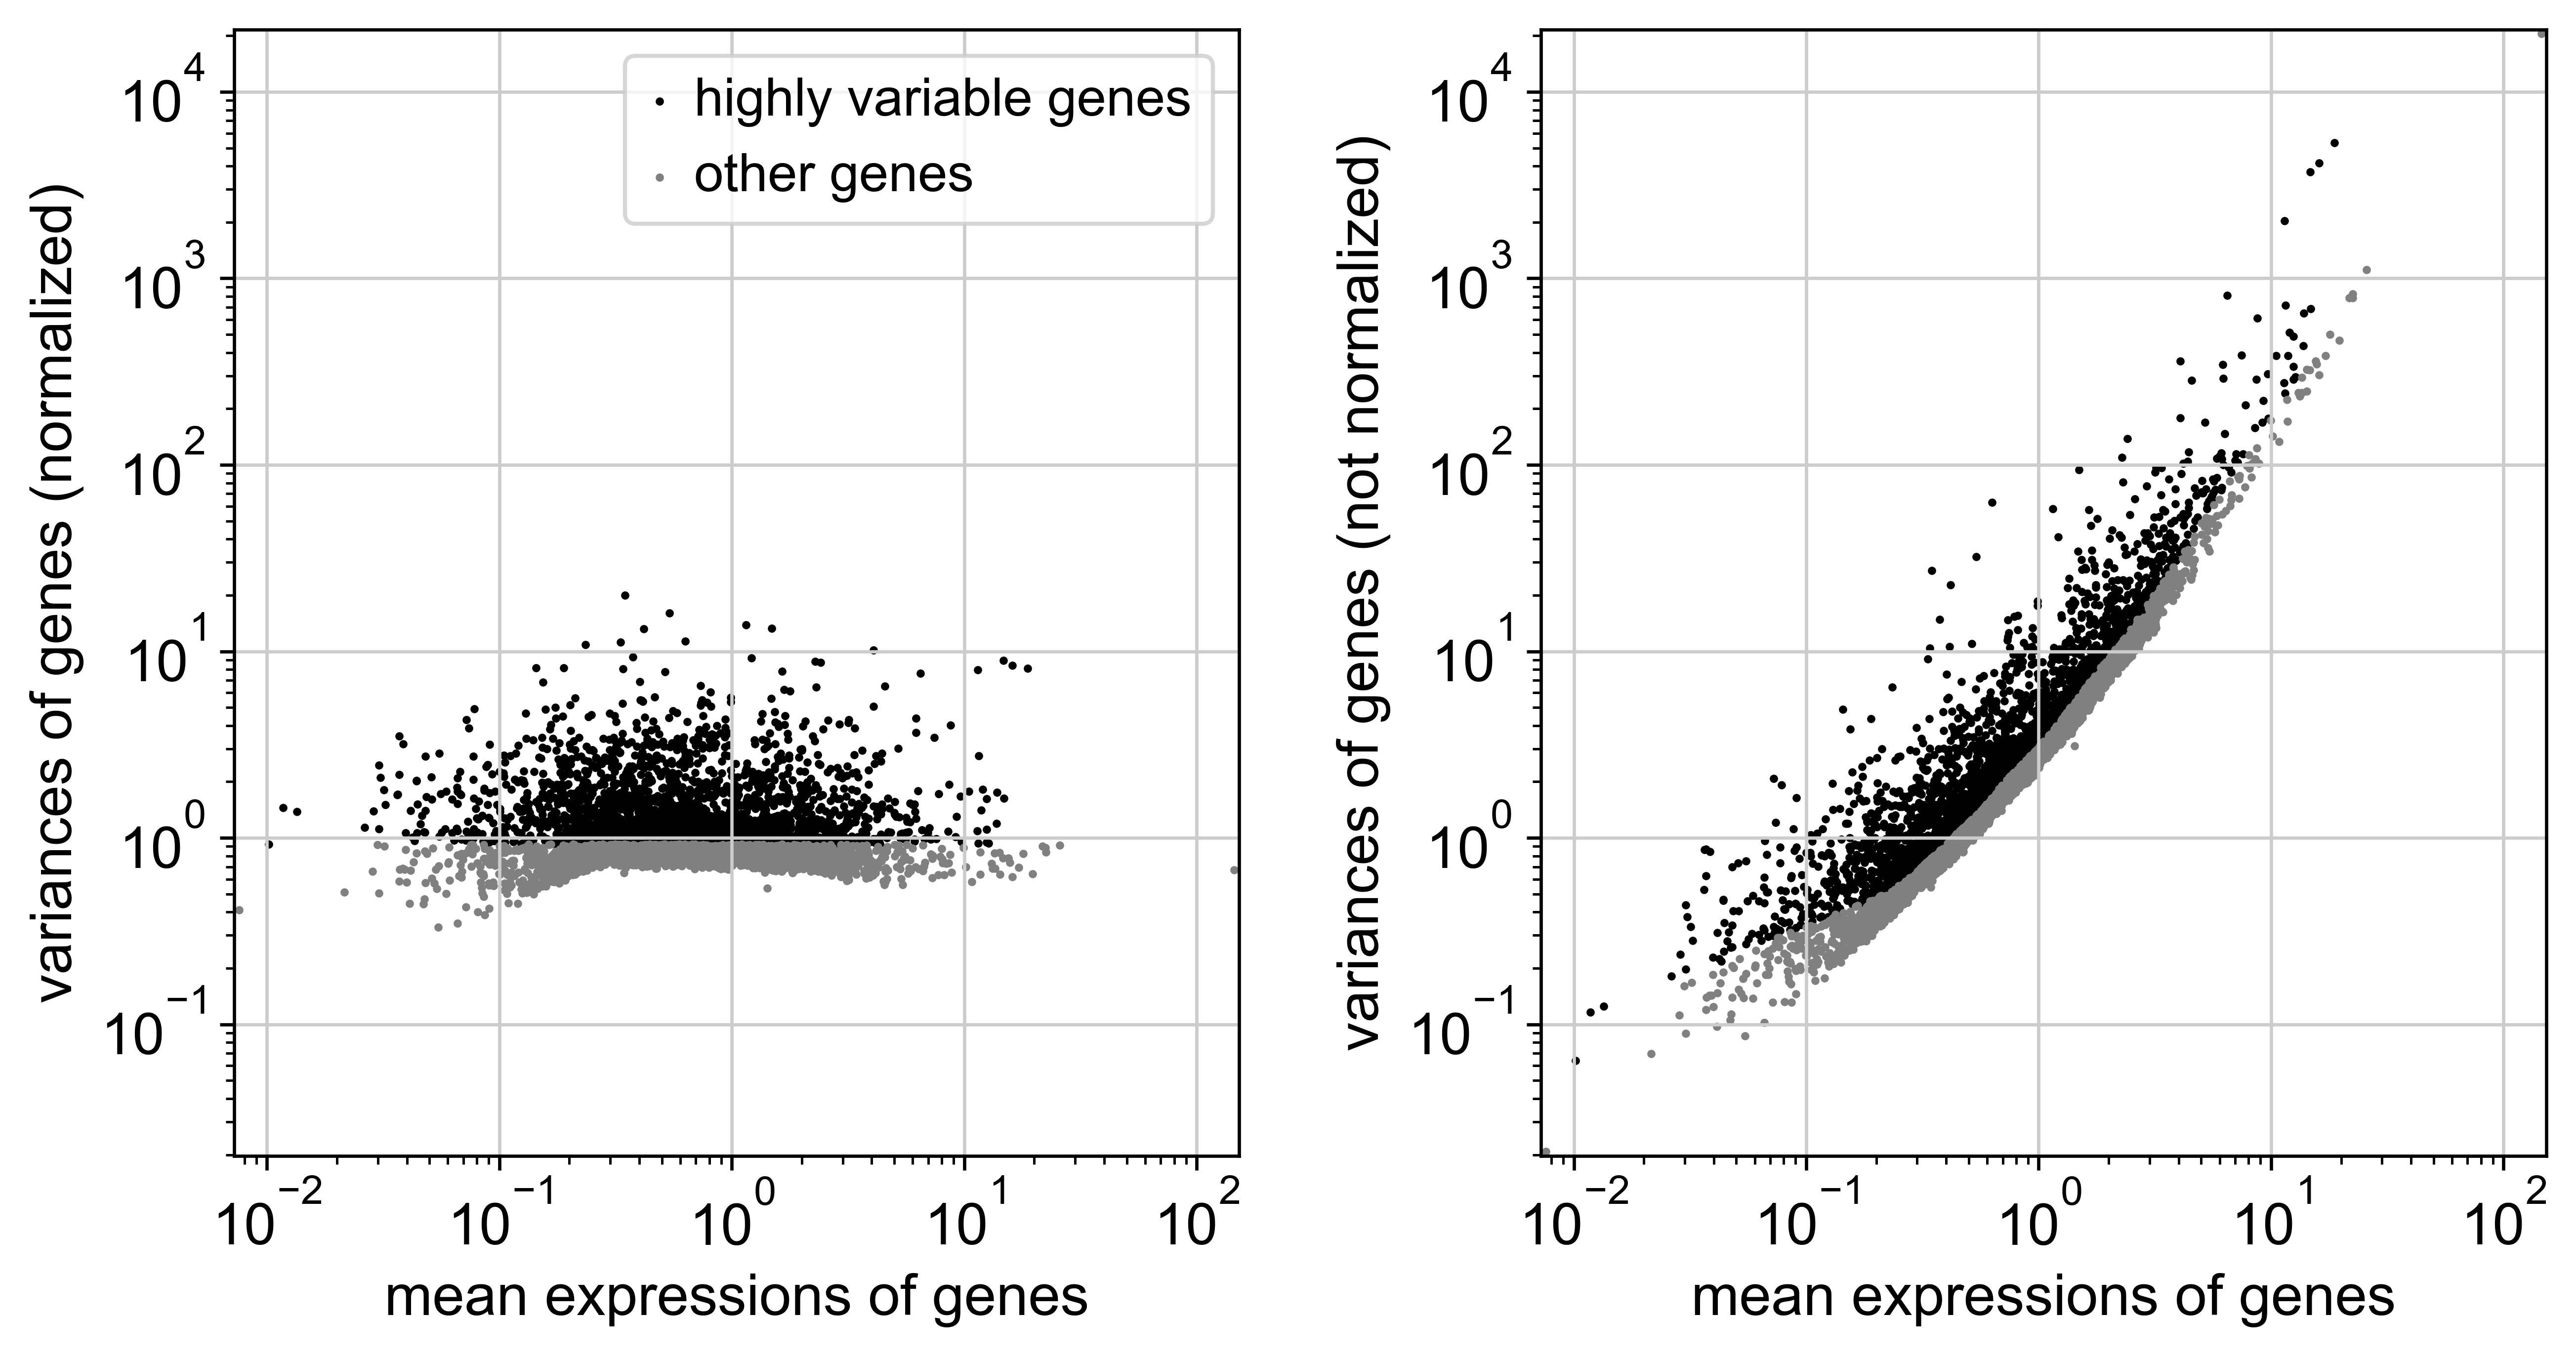

In [27]:
#Identify highly variable genes


sc.pp.highly_variable_genes(cdata, 
                            n_top_genes = 2500, 
                            flavor = "seurat_v3",#_paper", 
                            layer = "counts")


sc.pl.highly_variable_genes(cdata, save = "_seurat_v3_2500_aml_blasts_v1_2000counts.png", log = True)



In [28]:
cdata.uns["hvg_list"] = list(cdata[:, cdata.var.highly_variable].var.highly_variable.index)


In [29]:
#Select only highly variable genes
cdata = cdata[:, cdata.var.highly_variable]

In [30]:
# Z-score
sc.pp.scale(cdata, max_value = 10)

/Users/denis/mambaforge/envs/capseq_seurat_v3_fa/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [31]:
# find the number of non-random PCs

Z = cdata.X
d = find_num_pc(Z, start_pc = 200, sparse = False)
print ("Number of pc to use for is : "  + str(d["num_pc"]))

sc.tl.pca(cdata, n_comps = d["num_pc"], svd_solver = "arpack")



calculating the first 200 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 35 	 0.09 min.
2 	 35 	 0.17 min.
3 	 35 	 0.26 min.
4 	 35 	 0.32 min.
5 	 36 	 0.39 min.
6 	 35 	 0.45 min.
7 	 35 	 0.51 min.
8 	 35 	 0.58 min.
9 	 35 	 0.65 min.
10 	 35 	 0.71 min.
Number of pc to use for is : 35
computing PCA
    with n_comps=35
    finished (0:00:01)


In [37]:
#Batch correction
sc.external.pp.harmony_integrate(cdata, ["code_renamed"], max_iter_harmony = 20) #code_renamed
sc.pp.neighbors(cdata, n_neighbors = 15, use_rep = "X_pca_harmony")
sc.tl.umap(cdata, min_dist = 0.3, random_state = 69)


2025-02-06 13:08:56,462 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-06 13:08:57,657 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-06 13:08:57,700 - harmonypy - INFO - Iteration 1 of 20
2025-02-06 13:08:59,093 - harmonypy - INFO - Iteration 2 of 20
2025-02-06 13:09:01,386 - harmonypy - INFO - Converged after 2 iterations


computing neighbors
    finished (0:00:01)
computing UMAP
    finished (0:00:09)


In [66]:
sc.pp.neighbors(cdata, n_neighbors = 80, use_rep = "X_pca_harmony")

computing neighbors
    finished (0:00:06)


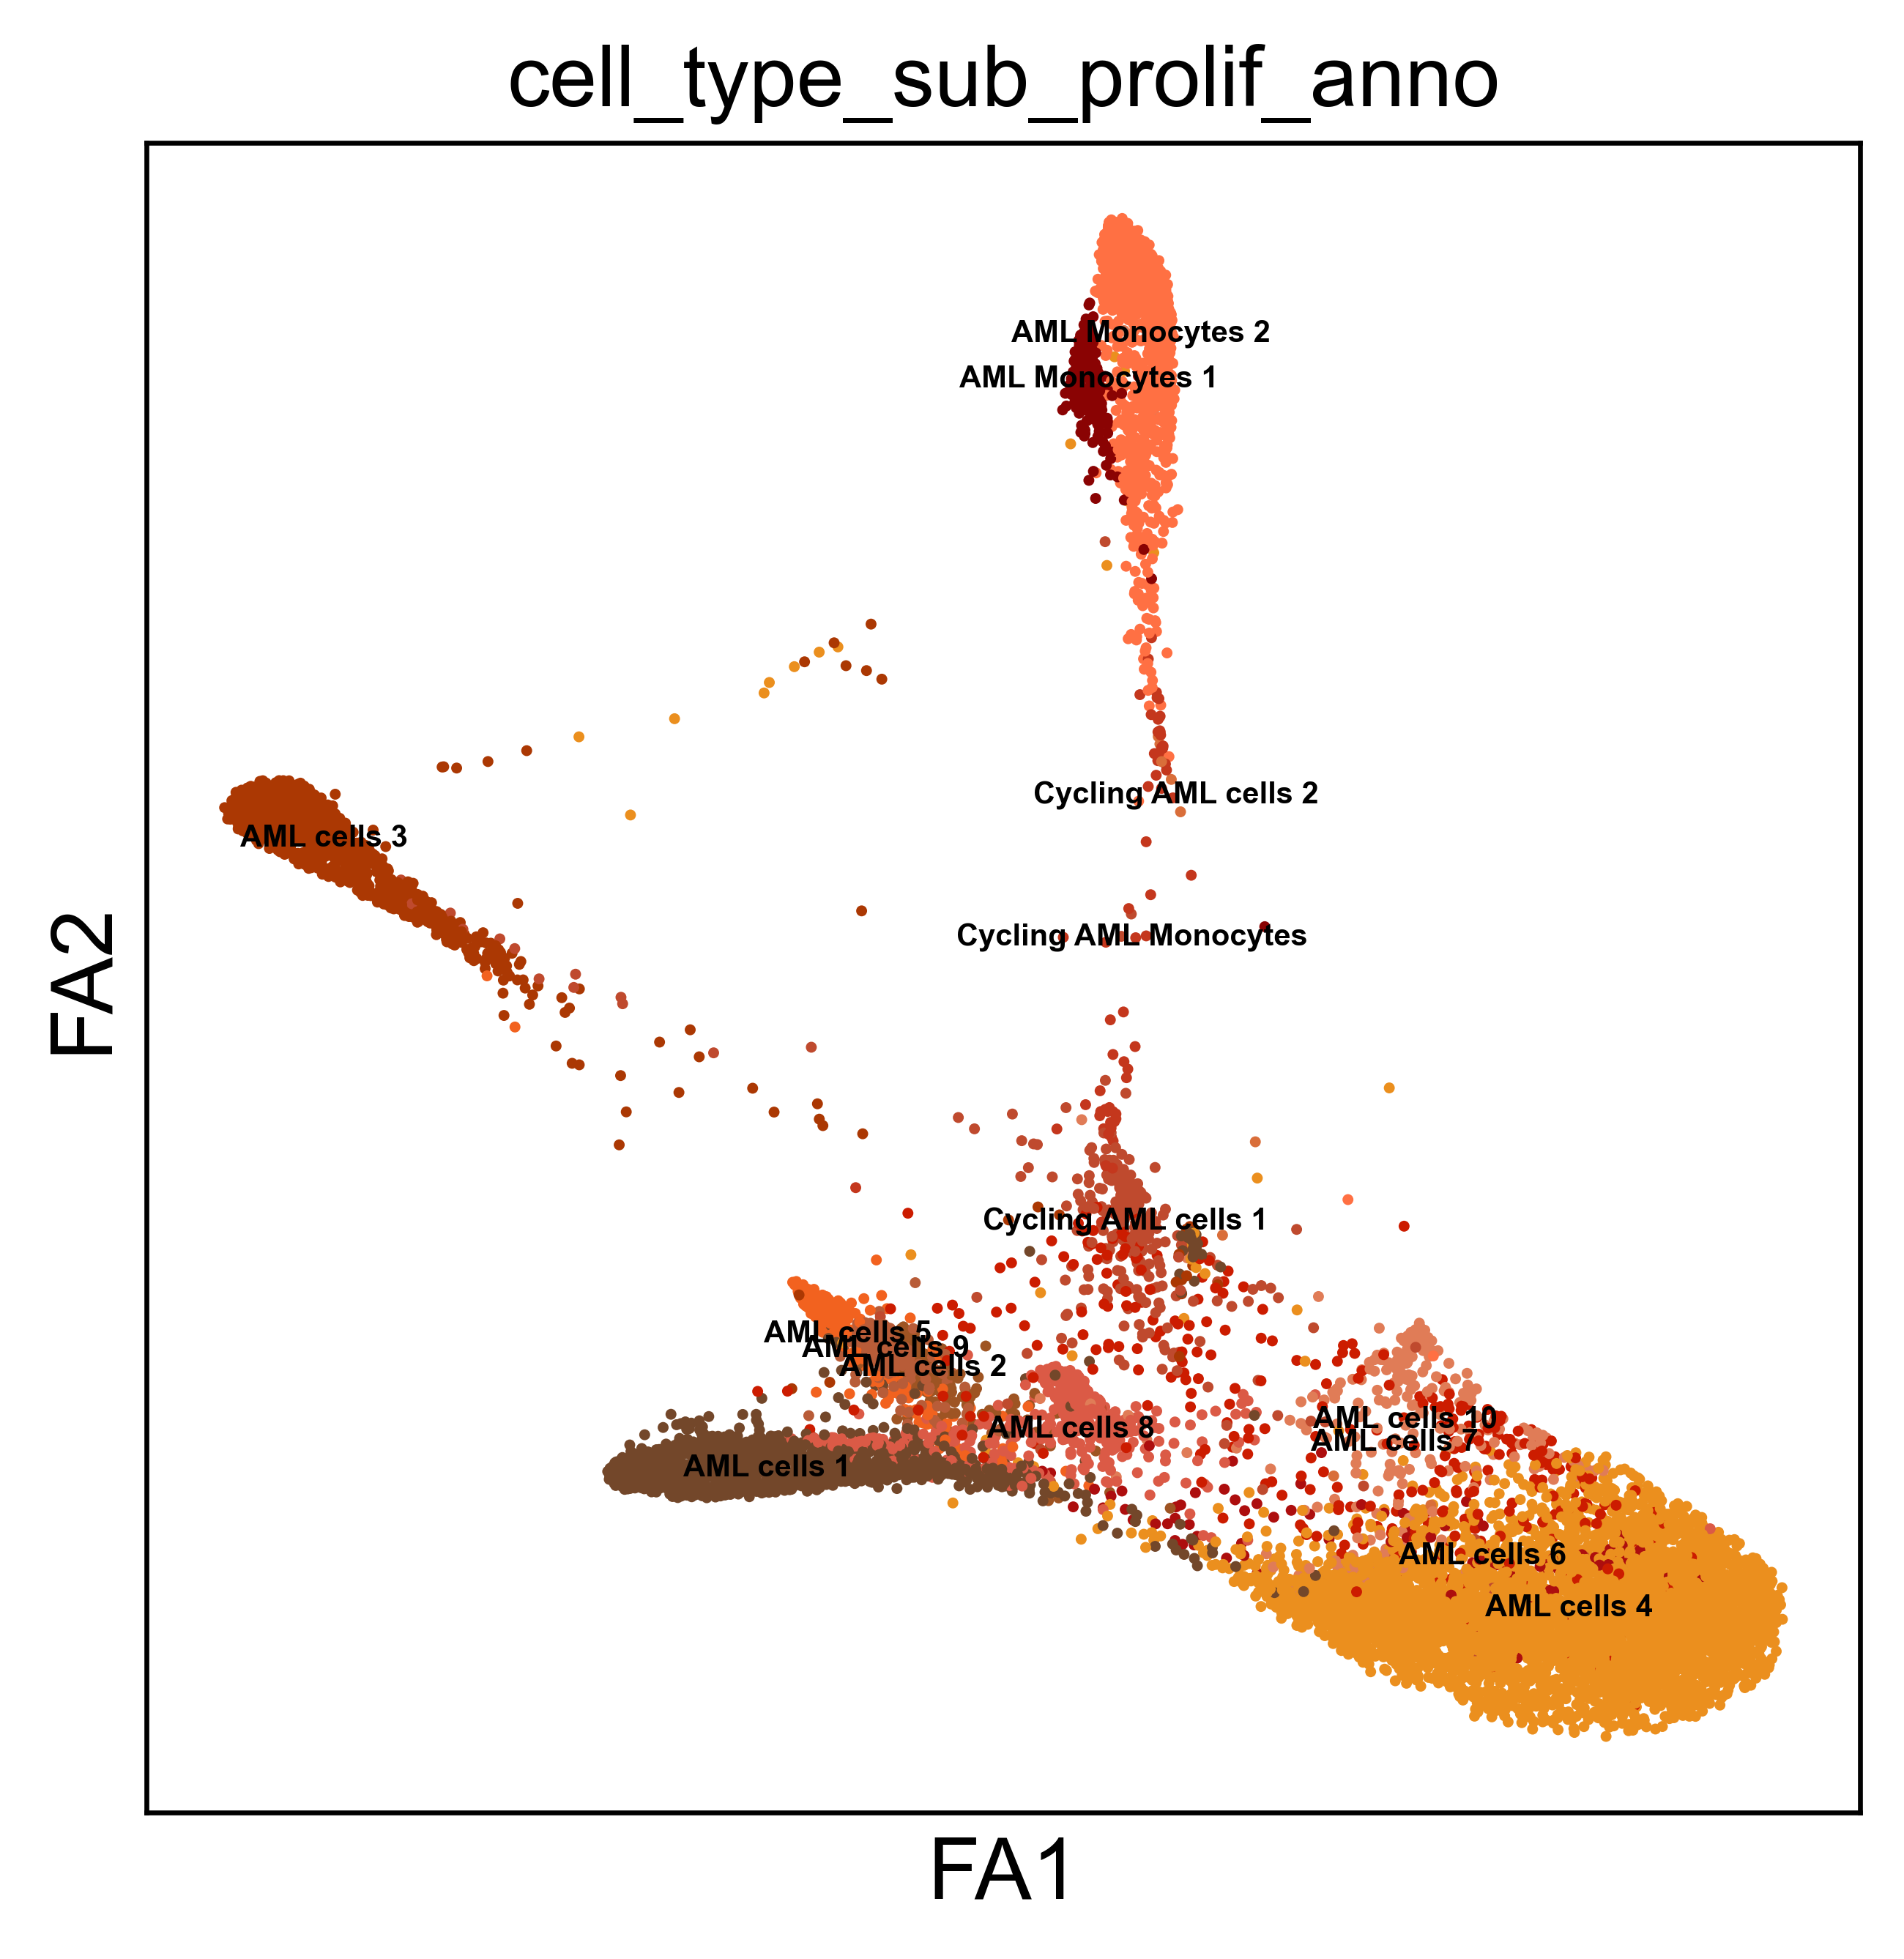

In [95]:
sc.pl.draw_graph(cdata, color=["cell_type_sub_prolif_anno"], legend_loc='on data', legend_fontsize=5)

In [98]:
cdata = cdata.raw.to_adata()
# Saving raw (original) counts to layer
cdata.layers["counts"] = cdata.X.copy()
# Save log-norm into .X
#normalize data
sc.pp.normalize_per_cell(cdata, counts_per_cell_after = 1e4) # n_counts is created
#logaritmize data
sc.pp.log1p(cdata)

fname1 = "backups/aml_cells_umap_2000counts_%dx%d_%s.h5ad"%(cdata.shape[0],cdata.shape[1],now())
print(fname1)
cdata.write(fname1)


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
backups/aml_cells_umap_2000counts_9352x37733_250206_15h14.h5ad
